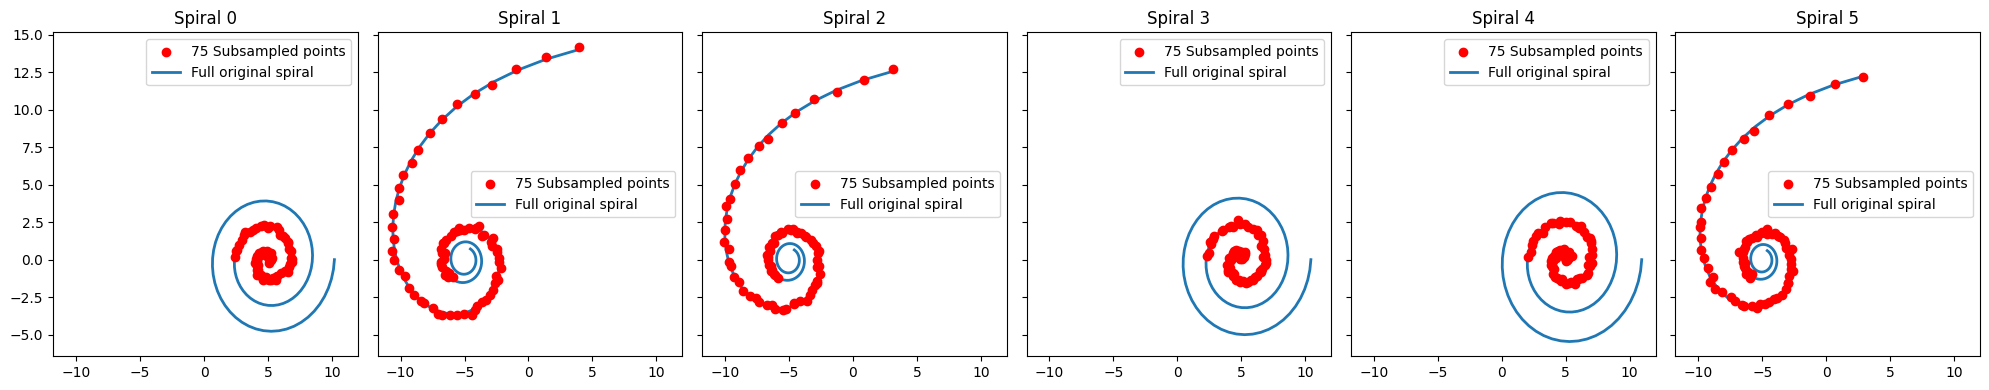

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import dataset
# Instantiate the dataset (using a small number for visualization)
data = dataset.SpiralDataset(nspiral=300, ntotal=150, start=0., stop=6 * np.pi, noise_std=0.1, noise_a=0.02, a=0.0, b=0.3, test=True)


# Create a figure with one subplot per spiral
fig, axs = plt.subplots(1, 6, figsize=(20, 4), sharex=True, sharey=True)
for i in range(6):
    # full original trajectory for the entire time span (all ntotal points)
    sample = data[i]
    subsampled = sample["values"].numpy()
    full_traj = data.orig_trajs[i] 
    axs[i].scatter(subsampled[:,:, 0], subsampled[:,:, 1], color="red", label="75 Subsampled points", zorder=5)
    axs[i].plot(full_traj[:, 0], full_traj[:, 1], label="Full original spiral", linewidth=2)
    axs[i].set_title(f"Spiral {i}")
    axs[i].legend()

plt.tight_layout()
plt.show()


In [2]:
test_dataset  = dataset.SpiralDataset(nspiral=100,test=True)
train_dataset = dataset.SpiralDataset(nspiral=200)
test_dataset_extrap  = dataset.SpiralDataset(nspiral=100,test=True,extrapolate=True)

In [140]:
test_dataset[0]['mask'],test_dataset_extrap[0]['mask']

(tensor([False,  True,  True, False, False, False,  True,  True, False,  True,
         False,  True, False, False, False,  True, False,  True, False,  True,
          True,  True,  True, False,  True, False, False,  True, False,  True,
         False, False, False,  True, False,  True,  True,  True,  True,  True,
         False,  True,  True, False, False, False,  True,  True, False,  True,
          True,  True,  True,  True,  True,  True, False, False, False,  True,
          True,  True,  True, False, False,  True,  True,  True,  True,  True,
          True,  True,  True,  True, False]),
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
      

In [326]:
from roma.model import (RoMAForPreTraining,RoMAForPreTrainingConfig, EncoderConfig)
from roma.trainer import Trainer, TrainerConfig
from roma.utils import get_encoder_size
import torch.nn as nn

from Interpolation_spirals.dataset import SpiralDataset
from roma.utils import load_from_checkpoint
from torch.utils.data import DataLoader

def evaluate():
    # Let's use the tiny model:
    encoder_args = get_encoder_size("RoMA-tiny")
    model = load_from_checkpoint("../checkpoints/checkpoint-10000", RoMAForPreTraining,RoMAForPreTrainingConfig)
    # model.load_weights("../checkpoints/checkpoint-10000")
    model.set_loss_fn(nn.MSELoss(reduction='sum'))
    data_to_evalutate = DataLoader(test_dataset,batch_size=1)
    loss        = 0
    predictions = []
    for sample in data_to_evalutate:
        prediction, ll = model(**sample )
        loss += ll.item()
        predictions.append(prediction)

    print(np.sqrt(loss)*1E-2)
    return predictions,loss


def extrapolate():
    # Let's use the tiny model:
    encoder_args = get_encoder_size("RoMA-tiny")
    model = load_from_checkpoint("../checkpoints/checkpoint-10000", RoMAForPreTraining,RoMAForPreTrainingConfig)
    # model.load_weights("../checkpoints/checkpoint-10000")
    model.set_loss_fn(nn.MSELoss(reduction='sum'))
    data_to_evalutate = DataLoader(test_dataset_extrap,batch_size=1)
    loss        = 0
    predictions = []

    Number_of_points_to_predict_interp = 45
    Number_of_points_to_predict_eextrap = 45


    for sample in data_to_evalutate:        

        start_idx           = 0
        end_idx             = start_idx + 80
        sample['values']    = sample['values'][:,start_idx:end_idx]
        sample['mask']      = sample['mask'][:,start_idx:end_idx]
        sample['positions'] = sample['positions'][:,:,start_idx:end_idx]

        sample['mask']      = torch.zeros_like(sample['mask'])
        random_indices      = torch.randperm(75)[:Number_of_points_to_predict_interp]
        sample['mask'][:,random_indices] = True 
        
        sample['mask'][:,75:] = True
        random_indices      = torch.randperm(end_idx-75)[:Number_of_points_to_predict_eextrap]


        prediction, ll = model(**sample)
        loss          += ll.item()
        predictions.append(prediction)



    print(np.sqrt(loss)*1E-2)
    return predictions,loss



In [327]:
predictions_extrap,loss_extrap  = extrapolate()


0.2849947961323793


In [4]:
predictions,loss             = evaluate()

0.09658391338554909


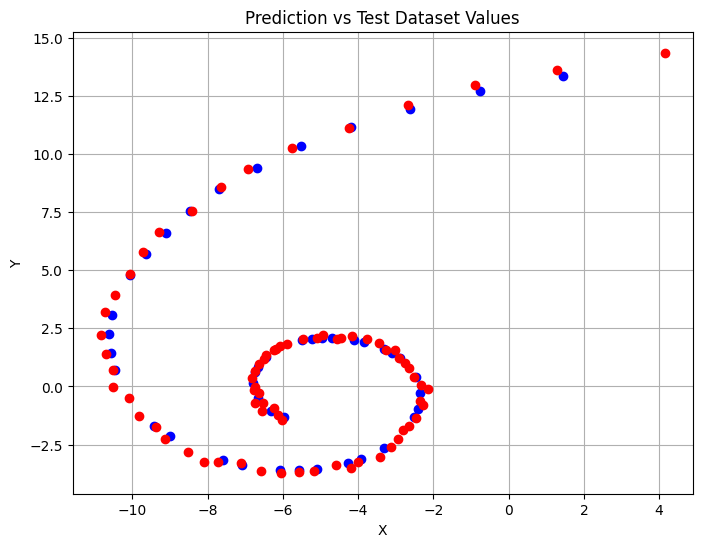

In [181]:
# Extract prediction and test dataset values
idx = 27
predicted_values = predictions[idx].detach().numpy()
sample      = test_dataset[idx]

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(predicted_values[:,:, 0], predicted_values[:,:, 1], label='Prediction', color='blue', marker='o')
subsampled = sample["values"].numpy()
plt.scatter(subsampled[:,:, 0], subsampled[:,:, 1], color="red", label="75 Subsampled points", zorder=5)
plt.title('Prediction vs Test Dataset Values')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend()
plt.grid()
plt.show()

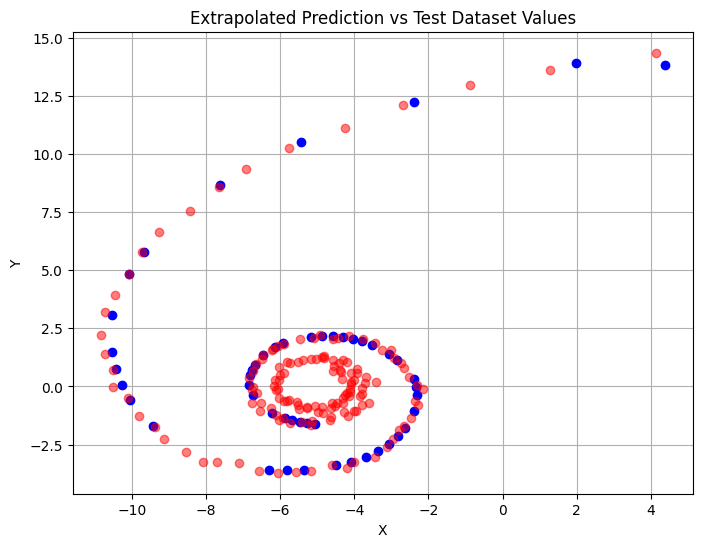

In [328]:
# Select an index for visualization

# Extract extrapolated prediction and test dataset values
predicted_extrap_values = predictions_extrap[idx].detach().numpy()
sample_extrap           = test_dataset_extrap[idx]

# Plot the data
plt.figure(figsize=(8, 6))
subsampled_extrap = sample_extrap["values"].numpy()

plt.scatter(subsampled_extrap[:, :, 0], subsampled_extrap[:, :, 1], color="red", label="Subsampled Points", zorder=5,alpha=0.5)


plt.plot(predicted_extrap_values[:, :, 0], predicted_extrap_values[:, :, 1], label='Extrapolated Prediction', color='blue', marker='o')
plt.title('Extrapolated Prediction vs Test Dataset Values')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend()
plt.grid()
plt.show()